#  --------------------------
 # 1. Data Loading and Preprocessing
 # --------------------------

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Thu Apr  3 08:31:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8       

In [ ]:
!uv pip install -q --system numba-cuda==0.4.0

In [ ]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [ ]:
!pip install ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.14
    Uninstalling aiohttp-3.11.14:
      Successfully uninstalled aiohttp-3.11.14


In [ ]:
import numpy as np
import pandas as pd
import cupy as cp
from numba import jit, cuda
import numba
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import requests
import threading
import websocket
import time
from datetime import datetime, timedelta
import json
import ccxt

In [ ]:
!curl ipinfo.io

{
  "ip": "34.141.219.33",
  "hostname": "33.219.141.34.bc.googleusercontent.com",
  "city": "Groningen",
  "region": "Groningen",
  "country": "NL",
  "loc": "53.2192,6.5667",
  "org": "AS396982 Google LLC",
  "postal": "9711",
  "timezone": "Europe/Amsterdam",
  "readme": "https://ipinfo.io/missingauth"
}

#Fetch for like specified minutes to have sufficient data for use

In [ ]:
combined_data = []
def on_order_book_message(ws, message):
    global combined_data
    data = json.loads(message)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")  # Proper timestamp format
    bids = data['b']  # List of bids [price, quantity]
    asks = data['a']  # List of asks [price, quantity]
    if bids and asks:
        bid_price = float(bids[0][0])  # Best bid price
        ask_price = float(asks[0][0])  # Best ask price
        # Append to combined data with placeholders for trade_price and volume
        combined_data.append({
            'timestamp': timestamp,
            'bid_price': bid_price,
            'ask_price': ask_price,
            'trade_price': None,  # Placeholder
            'volume': None  # Placeholder
        })

# Function to handle WebSocket messages for trade data (volume and close price)
def on_trade_message(ws, message):
    global combined_data
    data = json.loads(message)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")  # Proper timestamp format
    trade_price = float(data['k']['c'])  # Close price
    volume = float(data['k']['v'])  # Volume
    # Append to combined data with placeholders for bid_price and ask_price
    combined_data.append({
        'timestamp': timestamp,
        'bid_price': None,  # Placeholder
        'ask_price': None,  # Placeholder
        'trade_price': trade_price,
        'volume': volume
    })

# Function to run WebSocket for order book
def run_order_book_stream(symbol):
    url = f"wss://stream.binance.com:9443/ws/{symbol}@depth"
    ws = websocket.WebSocketApp(url, on_message=on_order_book_message)
    ws.run_forever()

# Function to run WebSocket for trade data
def run_trade_stream(symbol):
    url = f"wss://stream.binance.com:9443/ws/{symbol}@kline_1m"
    ws = websocket.WebSocketApp(url, on_message=on_trade_message)
    ws.run_forever()

# Main function to run both streams and save data
def collect_data(symbol, duration_minutes):
    global combined_data

    # Start WebSocket threads
    order_book_thread = threading.Thread(target=run_order_book_stream, args=(symbol,))
    trade_thread = threading.Thread(target=run_trade_stream, args=(symbol,))
    order_book_thread.start()
    trade_thread.start()

    # Run for the specified duration
    end_time = datetime.now() + timedelta(minutes=duration_minutes)
    while datetime.now() < end_time:
        pass
    combined_df = pd.DataFrame(combined_data)
    combined_df = combined_df.sort_values(by='timestamp')  # Sort by timestamp
    combined_df['bid_price'] = combined_df['bid_price'].fillna(method='ffill')
    combined_df['ask_price'] = combined_df['ask_price'].fillna(method='ffill')
    combined_df['trade_price'] = combined_df['trade_price'].fillna(method='ffill')
    combined_df['volume'] = combined_df['volume'].fillna(method='ffill')
    current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M")
    combined_df.to_csv(f"combined_data_{current_datetime}.csv", index=False)

    print("Data collection complete. File saved.")

symbol = 'btcusdt'
duration_minutes = 120
collect_data(symbol, duration_minutes)

Data collection complete. File saved.


<ipython-input-8-1ba6319232c4>:64: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['bid_price'] = combined_df['bid_price'].fillna(method='ffill')
<ipython-input-8-1ba6319232c4>:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['ask_price'] = combined_df['ask_price'].fillna(method='ffill')
<ipython-input-8-1ba6319232c4>:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['trade_price'] = combined_df['trade_price'].fillna(method='ffill')
<ipython-input-8-1ba6319232c4>:67: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['volume'] = combined_df['volume'].fillna(method='ffill')


In [ ]:
# save the file to drive



In [ ]:
data = pd.read_csv("/content/combined_data_2025-04-03_06-56.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp').resample('100ms').agg({
    #Change aggregation to 100ms for work
    'bid_price': 'first',
    'ask_price': 'first',
    'trade_price': 'last',
    'volume': 'sum'
})
data = data.dropna()
data = data.reset_index()
print(data)
data = data.reset_index()

                  timestamp  bid_price  ask_price  trade_price    volume
0   2025-04-03 06:46:14.000   83256.33   83256.34     83256.34   2.41632
1   2025-04-03 06:46:15.000   83255.98   83256.34     83256.34   2.41632
2   2025-04-03 06:46:16.000   83256.33   83256.34     83256.34   4.84954
3   2025-04-03 06:46:17.000   83256.33   83256.34     83256.34   2.42646
4   2025-04-03 06:46:18.000   83256.33   83256.34     83256.33   4.88392
..                      ...        ...        ...          ...       ...
672 2025-04-03 06:56:10.000   83124.74   83124.75     83120.00  25.53716
673 2025-04-03 06:56:10.100   83128.01   83120.00     83120.00  12.76858
674 2025-04-03 06:56:11.000   83119.99   83120.00     83120.00  19.15287
675 2025-04-03 06:56:12.000   83119.99   83120.00     83120.00  38.35084
676 2025-04-03 06:56:13.000   83119.99   83120.00     83120.00  19.17993

[677 rows x 5 columns]


In [ ]:
initial_price = data['trade_price'][0]

#Parametric formulation

In [ ]:
T = (data['timestamp'].max() - data['timestamp'].min()).total_seconds() # Total time
dt = (data['timestamp'][1] - data['timestamp'][0]).total_seconds()
N_t = len(data)
S_0 = data['trade_price'][0]

# Model parameters

In [ ]:
sigma = 0.2  #
kappa = 0.001
gamma = 0.0001
rho = 0.01
market_impact_param = 0.0001
inventory_max = 100

# State Space Discretization


In [ ]:
N_S = 101
N_I = 2 * 51 - 1
S_min = data['trade_price'].min() * 0.9
S_max = data['trade_price'].max() * 1.1
ds = (S_max - S_min) / (N_S - 1)
di = inventory_max / (N_I // 2)
S = np.linspace(S_min, S_max, N_S)
I = np.linspace(-inventory_max, inventory_max, N_I)
S_gpu = cp.asarray(S)
I_gpu = cp.asarray(I)

 # --------------------------
 # 2. Order Book Simulation
 # --------------------------

In [ ]:
class OrderBook:
    def __init__(self):
        self.bids = {}  # {price: volume}
        self.asks = {}

    def process_order(self, price, volume, is_bid):
        if is_bid:
            self.bids[price] = self.bids.get(price, 0) + volume
        else:
            self.asks[price] = self.asks.get(price, 0) + volume

    def execute_market_order(self, volume, is_bid):
        executed_volume = 0
        cost = 0

        if is_bid:  # Buying
            ask_prices = sorted(self.asks.keys())
            for price in ask_prices:
                available_volume = self.asks[price]
                trade_volume = min(volume - executed_volume, available_volume)
                cost += trade_volume * price
                executed_volume += trade_volume
                self.asks[price] -= trade_volume
                if self.asks[price] == 0:
                    del self.asks[price]
                if executed_volume == volume:
                    break
        else:  # Selling
            bid_prices = sorted(self.bids.keys(), reverse=True)
            for price in bid_prices:
                available_volume = self.bids[price]
                trade_volume = min(volume - executed_volume, available_volume)
                cost += trade_volume * price
                executed_volume += trade_volume
                self.bids[price] -= trade_volume
                if self.bids[price] == 0:
                    del self.bids[price]
                if executed_volume == volume:
                    break

        if executed_volume < volume:
            print(f"Warning: Could not execute full order ({volume}), only executed {executed_volume}")

        return cost, executed_volume

    def get_best_bid_ask(self):
        best_bid = max(self.bids.keys()) if self.bids else 0
        best_ask = min(self.asks.keys()) if self.asks else float('inf')
        return best_bid, best_ask

# --------------------------
 # 3. HJB Equation Solver
 # --------------------------

In [ ]:
# Utility function (risk aversion)
def U(x, rho):
    return -cp.exp(-rho * x)


@cuda.jit
def HJB_step_gpu(V_next, V_current, S, I, dt, ds, di, sigma, kappa, gamma, rho,
                 best_bid, best_ask, market_impact_param):
    s_idx, i_idx = cuda.grid(2)

    if s_idx > 0 and s_idx < S.shape[0] - 1 and i_idx > 0 and i_idx < I.shape[0] - 1:
        St = S[s_idx]
        It = I[i_idx]

        V_S_plus = V_next[s_idx + 1, i_idx]
        V_S_minus = V_next[s_idx - 1, i_idx]
        V_I_plus = V_next[s_idx, i_idx + 1]
        V_I_minus = V_next[s_idx, i_idx - 1]

        V_S = (V_S_plus - V_S_minus) / (2 * ds)
        V_SS = (V_S_plus - 2 * V_next[s_idx, i_idx] + V_S_minus) / (ds**2)
        V_I = (V_I_plus - V_I_minus) / (2 * di)

        # ---Market Maker's Control: Bid/Ask Spread---
        # ---This is a simplified control; in reality, it's a continuous optimization---

        # Replace Python list with a fixed-size array
        spread_change = cuda.local.array(5, dtype=numba.float32)
        spread_change[0] = -2 * ds
        spread_change[1] = -ds
        spread_change[2] = 0
        spread_change[3] = ds
        spread_change[4] = 2 * ds

        V_optimal = -float('inf')

        for i in range(5):  # Iterate over spread_change array
            for j in range(5):
                d_bid = spread_change[i]
                d_ask = spread_change[j]

                new_bid = best_bid + d_bid
                new_ask = best_ask + d_ask

                if new_bid > 0 and new_ask > 0 and new_bid < new_ask:  # Ensure valid prices
                    # ---Simplified model of order arrival and execution---
                    expected_buy = dt * 1  # Placeholder - Model order arrival better
                    expected_sell = dt * 1

                    expected_cost = (new_ask + market_impact_param * expected_buy) * expected_buy - \
                                    (new_bid - market_impact_param * expected_sell) * expected_sell

                    V_trade = -gamma * expected_cost + V_next[s_idx, i_idx] - kappa * It**2 * dt + \
                              dt * (0.5 * sigma**2 * St**2 * V_SS)

                    V_optimal = max(V_optimal, V_trade)

        V_current[s_idx, i_idx] = V_optimal


def solve_HJB_gpu(S_gpu, I_gpu, dt, ds, di, sigma, kappa, gamma, rho, U, N_t, data):
    V = cp.zeros((N_S, N_I, N_t))
    V[:, :, -1] = U(cp.zeros((N_S, N_I)), rho)  # Terminal condition

    threadsperblock = (8, 8)
    blockspergrid_x = int(np.ceil(V.shape[0] / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(V.shape[1] / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    for n in range(N_t - 2, -1, -1):
        best_bid = data['bid_price'][n]
        best_ask = data['ask_price'][n]

        HJB_step_gpu[blockspergrid, threadsperblock](
            V[:, :, n + 1], V[:, :, n], S_gpu, I_gpu, dt, ds, di,
            sigma, kappa, gamma, rho, best_bid, best_ask, market_impact_param
        )

    return cp.asnumpy(V)

In [ ]:
start_time = time.time()
V_optimal = solve_HJB_gpu(S_gpu, I_gpu, dt, ds, di, sigma, kappa, gamma, rho, U, N_t, data)
end_time = time.time()
print(f"HJB Solver Time: {end_time - start_time} seconds")


HJB Solver Time: 0.8226680755615234 seconds


#  --------------------------
 # 5. Extract Policy and Simulate Trades
 # --------------------------



In [ ]:
def get_policy(V, S, I, data, ds):
    policy = np.zeros((V.shape[0], V.shape[1], V.shape[2], 2))  # [bid_change, ask_change]

    for t_idx in range(V.shape[2]):
        best_bid = data['bid_price'][t_idx]
        best_ask = data['ask_price'][t_idx]

        for s_idx in range(1, V.shape[0] - 1):
            for i_idx in range(1, V.shape[1] - 1):

                optimal_action = [0, 0]  # [bid_change, ask_change]
                optimal_value = -float('inf')

                for d_bid in [-2 * ds, -ds, 0, ds, 2 * ds]:
                    for d_ask in [-2 * ds, -ds, 0, ds, 2 * ds]:

                        new_bid = best_bid + d_bid
                        new_ask = best_ask + d_ask

                        if new_bid > 0 and new_ask > 0 and new_bid < new_ask:
                            value = V[s_idx, i_idx, t_idx]  # Placeholder

                            if value > optimal_value:
                                optimal_value = value
                                optimal_action = [d_bid, d_ask]

                policy[s_idx, i_idx, t_idx] = optimal_action

    return policy


optimal_policy = get_policy(V_optimal, S, I, data, ds)


Simulation Results:
Final Wealth: 6411096.336259009
Final Inventory: -77


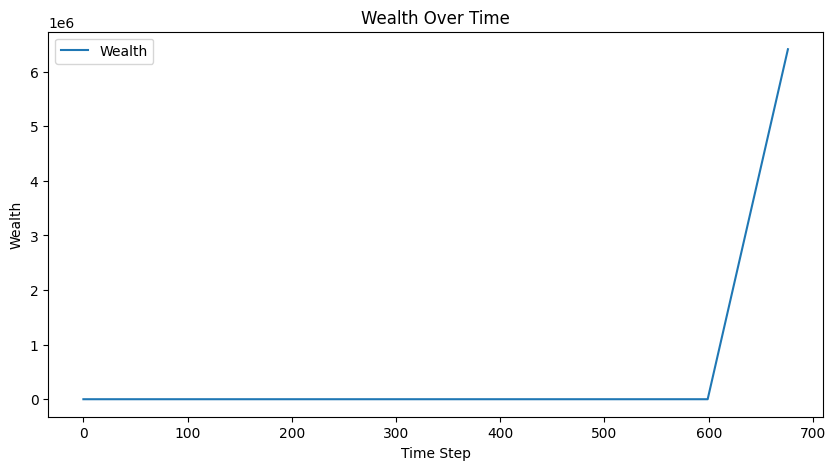

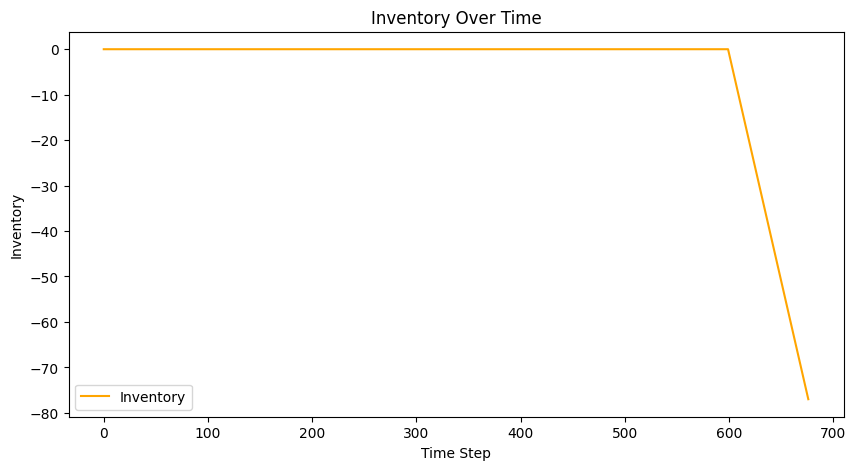

In [ ]:

def simulate_trades_with_order_book(data, S, I, policy, initial_wealth,
                                    initial_inventory, market_impact_param, gamma):
    wealth = initial_wealth
    inventory = initial_inventory
    order_book = OrderBook()

    wealth_history = [wealth]
    inventory_history = [inventory]
    bid_history = []
    ask_history = []

    for t_idx in range(len(data) - 1):

        # ---Get current market state---
        current_price = data['trade_price'][t_idx]

        # ---Find closest state indices---
        s_idx = np.argmin(np.abs(S - current_price))
        i_idx = np.argmin(np.abs(I - inventory))

        # ---Get action from policy---
        bid_change, ask_change = policy[min(s_idx, policy.shape[0] - 1),
                                        min(i_idx, policy.shape[1] - 1),
                                        t_idx]

        # ---Set market maker's quotes---
        best_bid, best_ask = order_book.get_best_bid_ask()
        if best_bid == 0:
            best_bid = data['bid_price'][t_idx]
        if best_ask == float('inf'):
            best_ask = data['ask_price'][t_idx]

        mm_bid = best_bid + bid_change
        mm_ask = best_ask + ask_change

        bid_history.append(mm_bid)
        ask_history.append(mm_ask)

        # ---Market orders from data---
        market_buy_volume = data['volume'][t_idx] if data['trade_price'][t_idx] > current_price else 0
        market_sell_volume = data['volume'][t_idx] if data['trade_price'][t_idx] < current_price else 0

        # ---Execute market maker trades---
        if mm_bid >= best_ask:  # Market maker buys
            cost, executed_volume = order_book.execute_market_order(1, True)
            wealth -= cost * (1 + gamma)
            inventory += executed_volume
        elif mm_ask <= best_bid:  # Market maker sells
            revenue, executed_volume = order_book.execute_market_order(1, False)
            wealth += revenue * (1 - gamma)
            inventory -= executed_volume
        else:
            order_book.process_order(mm_bid, 1, True)
            order_book.process_order(mm_ask, 1, False)

        # ---Update order book with market orders---
        order_book.execute_market_order(market_buy_volume, True)
        order_book.execute_market_order(market_sell_volume, False)

        wealth_history.append(wealth)
        inventory_history.append(inventory)

    return wealth_history, inventory_history, bid_history, ask_history


# ---Backtesting Parameters---
initial_wealth = 1000
initial_inventory = 0

# Run the simulation
wealth_history, inventory_history, bid_history, ask_history = simulate_trades_with_order_book(
    data, S, I, optimal_policy, initial_wealth, initial_inventory, market_impact_param, gamma
)

# Print final results
print("Simulation Results:")
print(f"Final Wealth: {wealth_history[-1]}")
print(f"Final Inventory: {inventory_history[-1]}")

# Plot results
import matplotlib.pyplot as plt

# Wealth plot
plt.figure(figsize=(10, 5))
plt.plot(wealth_history, label="Wealth")
plt.xlabel("Time Step")
plt.ylabel("Wealth")
plt.title("Wealth Over Time")
plt.legend()
plt.show()

# Inventory plot
plt.figure(figsize=(10, 5))
plt.plot(inventory_history, label="Inventory", color="orange")
plt.xlabel("Time Step")
plt.ylabel("Inventory")
plt.title("Inventory Over Time")
plt.legend()
plt.show()